# Week 17, Lecture 01 CodeAlong
- Coefficients & Feature Importance

## Lesson Objectives

- By the end of this lesson, students will be able to:
    - Extract feature names from sklearn v1.1 objects
    - Extract and visualize coefficients
    - Save models to a joblib file


# Business Problem

The World Health Organization is creating a task force to increase life expectancy around the world.  They want to to focus their efforts on areas where countries can change to help their people live longer.

They have tasked you with identifying which statistics about each county have the greatest impact on life expectancy and how those could change in increase the lifespan of the population.

### The Data

Data comes from the World Health Organization.  It describes demographic, health, and economic data from countries around the world between 2000 and 2015. 

Each row is one country during one year.

> Task Inspired by: https://medium.com/@shanzehhaji/using-a-linear-regression-model-to-predict-life-expectancy-de3aef66ac21

- Kaggle Dataset on Life Expectancy:
    - https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import set_config
set_config(transform_output='pandas')

import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
df = pd.read_csv("Data/Life Expectancy Data.csv")
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9


In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")



In [4]:
# clean extra spaces
df.columns = df.columns.str.strip()
df

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


In [5]:
pd.set_option('display.max_columns',0)
df

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,27.1,42,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,26.7,41,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,26.3,40,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,25.9,39,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


## EDA

In [6]:
df.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

> Can't have null values for the target!

In [7]:
# drop null values ONLY FROM TARGET
df = df.dropna(subset=['Life expectancy'])

In [8]:
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2928.00000,2928.000000,2928.000000,2928.000000,2735.000000,2928.000000,2375.000000,2928.000000,2896.000000,2928.000000,2909.000000,2702.000000,2909.000000,2928.000000,2485.000000,2.284000e+03,2896.000000,2896.000000,2768.000000,2768.000000
mean,2007.50000,69.224932,164.796448,30.407445,4.614856,740.321185,80.960842,2427.855874,38.235394,42.179303,82.548298,5.930163,82.321416,1.747712,7494.210719,1.276454e+07,4.850622,4.881423,0.627419,11.999639
std,4.61056,9.523867,124.292079,118.114450,4.050749,1990.930605,25.018337,11485.970937,19.959590,160.700547,23.416674,2.483273,23.706644,5.085542,14282.251492,6.103765e+07,4.420829,4.509609,0.210978,3.346440
min,2000.00000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2003.75000,63.100000,74.000000,0.000000,0.905000,4.853964,77.000000,0.000000,19.300000,0.000000,78.000000,4.260000,78.000000,0.100000,463.852618,1.966738e+05,1.600000,1.575000,0.493000,10.100000
50%,2007.50000,72.100000,144.000000,3.000000,3.770000,65.611455,92.000000,17.000000,43.350000,4.000000,93.000000,5.750000,93.000000,0.100000,1764.973870,1.391756e+06,3.300000,3.400000,0.677000,12.300000
75%,2011.25000,75.700000,228.000000,22.000000,7.715000,442.614322,97.000000,362.250000,56.100000,28.000000,97.000000,7.490000,97.000000,0.800000,5932.899677,7.426746e+06,7.200000,7.200000,0.779250,14.300000
max,2015.00000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,77.600000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


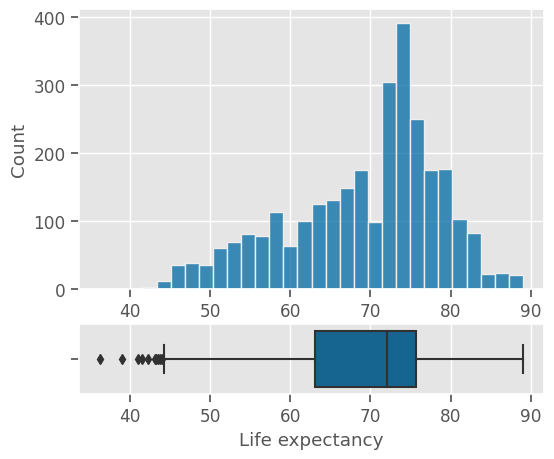

In [9]:
target = 'Life expectancy'

grid_spec = {'height_ratios':[0.8,0.2]}
fig, axes = plt.subplots(nrows=2, figsize=(6,5), gridspec_kw=grid_spec)

sns.histplot(data=df, x=target,ax=axes[0])
sns.boxplot(data=df, x=target, ax=axes[1]);

## Preprocessing (with Sklearn v1.1+)

In [10]:
# ### Train Test Split
## Make x and y variables
target = "Life expectancy"
drop_feats = []

y = df[target].copy()
X = df.drop(columns=[target, *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head(3)

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2414,South Sudan,2010,Developing,359.0,27,NaN,0.000000,NaN,0,NaN,41,NaN,NaN,NaN,4.0,1562.239346,167192.0,NaN,NaN,0.000,0.0
1576,Malawi,2009,Developing,491.0,36,1.16,7.915071,93.0,21,17.3,56,93.0,1.18,93.0,14.9,42.737966,1471462.0,6.9,6.8,0.415,9.9
2559,Tajikistan,2009,Developing,174.0,10,0.30,35.716138,93.0,0,35.9,12,93.0,5.93,93.0,0.2,666.345857,7472819.0,3.7,3.8,0.601,11.1


### Drop Country Columns

We are going to drop the country columns.  Why?  3 reasons:

1. The ultimate goal of the business problem is to focus on high impact areas of change.  A country cannot change what it is.  Zimbabwe cannot become Sweden!  Instead, we will focus on the features that CAN be changed.

2. After one-hot encoding there are too many features to analyze.  We need to reduce our focus

3. one-hot encoded countries add multi-collinearity to our features, reducing the reliability of our analysis.

In [11]:
X_train = X_train.drop(columns='Country')
X_test = X_test.drop(columns='Country')

### Categorical Processing Pipeline

In [12]:
## Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
mean_imputer = SimpleImputer(strategy='mean')

num_tuple = ('Numeric', mean_imputer, num_sel)

### Numeric Processing Pipeline

<center> <font color='red' size=5>Notice We Are Not Scaling!!! </font>
    
   **<center> Q: Why not? </center>**

In [13]:
## Make categorical preprocessing pipeline
## Drop one of the binary columns after OHE to reduce multicollinearity
cat_sel = make_column_selector(dtype_include='object')

cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', 
                                       sparse_output=False,
                                       drop='if_binary'))

cat_tuple = ('Categorical', cat_pipe, cat_sel)

In [14]:
## make the preprocessing column transformer
preprocessor = ColumnTransformer([num_tuple, cat_tuple],
                                verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('Numeric', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000142040B92D0>),
                                ('Categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000142040B9360>)],
                  verbose_feature_names_out=False)

### Creating Unscaled Processed df

In [15]:
## fit preprocessor and transform data
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)
X_train_proc.head()

,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developing
2414,2010.0,359.0,27.0,4.580078,0.000000,81.438929,0.0,38.113041,41.0,82.490834,5.931982,82.451879,4.0,1562.239346,167192.0,4.811567,4.819493,0.000,0.0,1.0
1576,2009.0,491.0,36.0,1.160000,7.915071,93.000000,21.0,17.300000,56.0,93.000000,1.180000,93.000000,14.9,42.737966,1471462.0,6.900000,6.800000,0.415,9.9,1.0
2559,2009.0,174.0,10.0,0.300000,35.716138,93.000000,0.0,35.900000,12.0,93.000000,5.930000,93.000000,0.2,666.345857,7472819.0,3.700000,3.800000,0.601,11.1,1.0
1524,2013.0,178.0,0.0,15.040000,1968.816817,93.000000,35.0,61.400000,0.0,93.000000,6.590000,93.000000,0.1,15712.823760,2957689.0,2.700000,2.700000,0.834,16.4,0.0
33,2014.0,11.0,21.0,0.010000,54.237318,95.000000,0.0,58.400000,24.0,95.000000,7.210000,95.000000,0.1,547.851700,39113313.0,6.000000,5.800000,0.741,14.4,1.0


# Modeling - Linear Regression

### Linear Model Assumptions

**Linearity:**
That the input features have a linear relationship with the target.

**Independence of Features:** (AKA Little-to-No Multicollinearity)
That the features are not strongly related to other features.

**Normality:**
The model's residuals are approximately normally distributed.

**Homoscedasticity:**
The model residuals have equal variance across all predictions.

## Model 1: LinReg

In [16]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_proc, y_train)
evaluate_regression(lin_reg, X_train_proc, y_train, 
                    X_test_proc, y_test)

Split,R^2,MAE,RMSE
Train,0.82,3.00,4.02
Test,0.82,3.06,4.12


### Extracting and Visualizing Coefficients

#### Extracting Coefficients from lin_reg

In [17]:
# access the .coef_ 
lin_reg.coef_


array([-1.67570818e-02, -1.93424440e-02,  1.07022049e-01,  5.55952621e-02,
        2.13604624e-05, -9.58554743e-03, -2.74178194e-05,  3.90620391e-02,
       -8.10436910e-02,  2.50137362e-02,  1.06217157e-01,  3.76506051e-02,
       -4.78895688e-01,  4.45034481e-05,  4.18631809e-09, -4.97650015e-02,
       -2.65388724e-02,  5.73701612e+00,  6.85728848e-01, -1.48439919e+00])

In [18]:
# Intercept
lin_reg.intercept_


89.69300579166091

In [19]:
## Saving the coefficients
coefs = pd.Series(lin_reg.coef_, index=lin_reg.feature_names_in_)
coefs


Year                              -1.675708e-02
Adult Mortality                   -1.934244e-02
infant deaths                      1.070220e-01
Alcohol                            5.559526e-02
percentage expenditure             2.136046e-05
Hepatitis B                       -9.585547e-03
Measles                           -2.741782e-05
BMI                                3.906204e-02
under-five deaths                 -8.104369e-02
Polio                              2.501374e-02
Total expenditure                  1.062172e-01
Diphtheria                         3.765061e-02
HIV/AIDS                          -4.788957e-01
GDP                                4.450345e-05
Population                         4.186318e-09
thinness  1-19 years              -4.976500e-02
thinness 5-9 years                -2.653887e-02
Income composition of resources    5.737016e+00
Schooling                          6.857288e-01
Status_Developing                 -1.484399e+00
dtype: float64

### def `get_coefficients`

In [20]:
## formatting numbers to not use , thousands sep, and 4 digits floats
pd.set_option('display.float_format', lambda x: f"{x:,.4f}")


In [21]:
## show coefs again
coefs


Year                              -0.0168
Adult Mortality                   -0.0193
infant deaths                      0.1070
Alcohol                            0.0556
percentage expenditure             0.0000
Hepatitis B                       -0.0096
Measles                           -0.0000
BMI                                0.0391
under-five deaths                 -0.0810
Polio                              0.0250
Total expenditure                  0.1062
Diphtheria                         0.0377
HIV/AIDS                          -0.4789
GDP                                0.0000
Population                         0.0000
thinness  1-19 years              -0.0498
thinness 5-9 years                -0.0265
Income composition of resources    5.7370
Schooling                          0.6857
Status_Developing                 -1.4844
dtype: float64

In [22]:
X_train_proc.iloc[0]

Year                                2,010.0000
Adult Mortality                       359.0000
infant deaths                          27.0000
Alcohol                                 4.5801
percentage expenditure                  0.0000
Hepatitis B                            81.4389
Measles                                 0.0000
BMI                                    38.1130
under-five deaths                      41.0000
Polio                                  82.4908
Total expenditure                       5.9320
Diphtheria                             82.4519
HIV/AIDS                                4.0000
GDP                                 1,562.2393
Population                        167,192.0000
thinness  1-19 years                    4.8116
thinness 5-9 years                      4.8195
Income composition of resources         0.0000
Schooling                               0.0000
Status_Developing                       1.0000
Name: 2414, dtype: float64

In [23]:
# Define get_coefficients function to extract LinReg coefficients



## Visualizing Coefficients

In [24]:
## Plot Coefficients



In [31]:
## Function for plotting coefficients

def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [32]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

# Understanding Coefficients

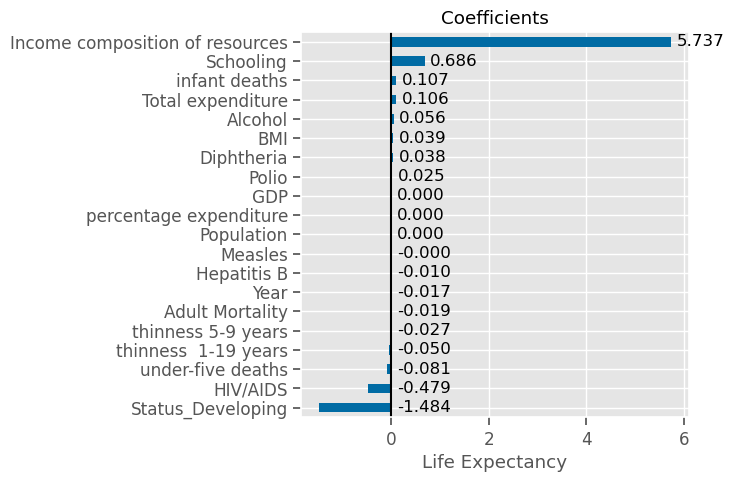

In [33]:
## Display Coefficients

## Plot sorted Coefficients
ax = plot_coefficients(coefs)
annotate_hbars(ax)
plt.savefig('life_expectancy_coefficients.png')

> ***Q1: What do we notice about our coefficients? Is there anything odd that would be difficult to a stakeholder?***

Why does GDP per Capita seem to have no effect on Life Expectancy?

In [ ]:
# Median GDP



The median GDP per Capita in the dataset is $3,184 US.

In [ ]:
# GDP Coefficient



GDP per Capita adds 1 year of life for every 44,500 US Dollars of GDP per Capita.  

In [ ]:
## Effect of median GDP on target



Countries with the median average GDP per Capita add about 2 months of expected life from this feature.

In [ ]:
## Max GDP



In [ ]:
# Effect: Max GDP times coefficient



The country with the highest GDP per Capita adds 5 years to life expectancy with this feature.

In [ ]:
# What country is that?




What about Population?

In [ ]:
# Population coefficient



In [ ]:
# Population median



In [ ]:
# effect of coefficient on median population country



The countries with a median average population add less than a day to their life expectancy.

However...

In [ ]:
# Max population



In [ ]:
# Effect of max population on target



The country with the highest population adds 5 years as a result of the population size!

In [ ]:
## What country is that?



## Feature Importance

**Feature importance does <span style="color:red"> NOT </span> describe the relationship between features targets.**

**It only describes what the model is focusing on to make its predictions.**

**Think of the results as percentage weights on the features for how important they are.**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_proc, y_train)
evaluate_regression(rf_reg, X_train_proc, y_train, 
                    X_test_proc, y_test)

> Using the models .feature_names_in_

In [ ]:
# Extract Feature Importances
rf_reg.feature_importances_



In [ ]:
# create a function to extract importances
importances = pd.Series(rf_reg.feature_importances_, index=rf_reg.feature_names_in_).sort_values()
importances



In [ ]:
# show importances Series
importances.plot(kind='barh')

In [ ]:
# Plot Importances
def plot_importances(importances, title='importances'):
    ax = importances.plot(kind='barh')
    ax.set_title(title)
    plt.show()

plot_importances(importances, title='importances to life expectancies')



> **Q1:** What do these numbers mean?

> **Q2:** What are the top 5 most important features?

## Using joblib to Save our Model, Data, and Objects

In [ ]:
X_train.head()

In [ ]:
import joblib, os

## creating a dictionary of all of the variables to save for later
to_save = {'X_train': X_train,
           'X_test': X_test,
           'y_train':y_train,
           'y_test':y_test,
           'preprocessor':preprocessor,
           'RandomForestRegressor':rf_reg,
           'LinearRegression':lin_reg}



In [ ]:
# Create the folder to save it in
folder = '/Models/'
filename = 'wk1-lect01-codealong.joblib'
os.makedirs(folder, exist_ok=True)

In [ ]:
# Save the models, data, and preprocessor
joblib.dump(to_save, folder + filename)



In [ ]:
# try loading again to make sure it works.

saved_stuff = joblib.load(folder + filename)
saved_stuff.keys()

> We will continue working with this task and these models next class!

# *Teaser* Shap (For Regression)

In [ ]:
# Import and init shap
import shap
shap.initjs()

<font color='red'><center>We MUST preprocess the data ahead of time for SHAP</center></font>

In [ ]:
# Take a sample of the training data
X_shap = shap.sample(X_train_proc, nsamples = 500, random_state=SEED)
y_shap = y_train.loc[X_shap.index]

# Instantiate a Model Explainer with the model
explainer = shap.Explainer(rf_reg)

## Get shap values form the explainer
shap_values = explainer(X_shap,y_shap)

In [ ]:
shap.summary_plot(shap_values, features = X_shap)